## **Study and Experiments on Neural Networks and Clustering**

In [13]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

cudnn.benchmark = True
plt.ion()

Here I have downloaded dataset directly from the given link and extract it using zipFile library. Earlier I was using Google Drive which would require to login to google drive(not recoomended)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
import urllib.request
import zipfile
url='https://download.pytorch.org/tutorial/hymenoptera_data.zip'
filename = 'hymenoptera_data.zip'

# download the zip file from the URL
urllib.request.urlretrieve(url, filename)

# open the zip file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    # extract all the files in the zip file to a folder
    zip_ref.extractall('data_folder')


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = '/content/drive/MyDrive/hymenoptera_data/'
data_dir = 'data_folder/hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


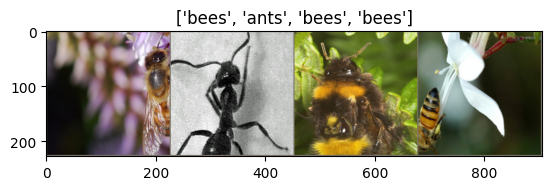

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Identity()
print(num_ftrs)
print(type(model_ft))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


512
<class 'torchvision.models.resnet.ResNet'>


In [8]:
def get_resnet18_features(image_folder_path):
    # Define ResNet18 model
    resnet18 = models.resnet18(pretrained=True)
    resnet18.fc = torch.nn.Identity() # Remove final fully connected layer

    # Define data transformations
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load image dataset
    image_dataset = ImageFolder(image_folder_path, transform=transform)
    resnet18_features = []
    labels = []
    for image,label in image_dataset:
            features = model_ft(image.unsqueeze(0))
            resnet18_features.append(features.detach().numpy().squeeze())
            labels.append(label)
    return (resnet18_features),np.array(labels)

In [9]:
image_datasets = ImageFolder('data_folder/hymenoptera_data/train')
train_features,labels_train = get_resnet18_features(image_datasets.root)

In [10]:
train_array = np.array(train_features)
print(labels_train.shape)
print(train_array.shape)
print(len(train_features))

(244,)
(244, 512)
244


In [11]:
image_datasets = ImageFolder('data_folder/hymenoptera_data/val')
test_features,labels_test = get_resnet18_features(image_datasets.root)
test_array = np.array(test_features)
print(labels_test.shape)
print((test_array))
print(test_array.shape)

(153,)
[[0.9030223  0.8657196  0.94263285 ... 0.918485   1.0282812  0.9509854 ]
 [0.9017365  0.9482257  0.9560097  ... 0.9328947  1.0353359  1.021719  ]
 [0.7976131  0.93748796 0.999041   ... 0.9211579  1.035994   0.94427156]
 ...
 [0.9390871  0.89510363 0.8955561  ... 0.9174817  0.97365767 1.0039194 ]
 [0.90514153 0.99731493 0.88021183 ... 0.87210464 1.0110254  0.9649107 ]
 [0.94048893 0.9405628  0.8899761  ... 0.9085284  1.031165   0.903254  ]]
(153, 512)



In this task we have to Compare L2 regularized logistic regression, RBF kernel SVM and random forest for the test data using accuracy and f1_score and matrix.

I have created the three different classifier i.e. L2 regularized logistic regression, RBF kernel SVM and random forest with GridSearch CV for finding best hyperparameters in the latter two.
I have the classification report(for f1_score and accuracy) and confusion matrix for each classifier from which we can interpret the result

In [14]:
# Load data
X_train = train_array
y_train = labels_train
X_test = test_array
y_test = labels_test


# L2 regularized logistic regression
lr = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)


# RBF kernel SVM
svm = SVC(kernel='rbf', random_state=42)
svm_params = {'C': [0.1, 1, 10,50,100], 'gamma': [0.01, 0.1, 1,10]}
svm_gs = GridSearchCV(svm, svm_params, scoring='accuracy', cv=5)
svm_gs.fit(X_train, y_train)


# Random forest
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200, 500,1000], 'max_depth': [0.5,1,2,5, 10, 20]}
rf_gs = GridSearchCV(rf, rf_params, scoring='accuracy', cv=5)
rf_gs.fit(X_train, y_train)


# Print results
print('Logistic regression:' )
print(classification_report(y_test, lr.predict(X_test)))
print(confusion_matrix(y_test, lr.predict(X_test)))
print('RBF kernel SVM:' )
print("Best parameter for SVM with Kernel RBF Classification : ", svm_gs.best_params_)
print("Best score  for SVM with Kernel RBF Classification: ", svm_gs.best_score_)
print(classification_report(y_test,svm_gs.predict(X_test)))
print(confusion_matrix(y_test,svm_gs.predict(X_test)))
print('Random forest: ')
print("Best parameter for Random Forest Classification : ", rf_gs.best_params_)
print("Best score  for Random Forest Classification: ", rf_gs.best_score_)
print(classification_report(y_test, rf_gs.predict(X_test)))
print(confusion_matrix(y_test, rf_gs.predict(X_test)))


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Logistic regression:
              precision    recall  f1-score   support

           0       0.61      0.60      0.60        70
           1       0.67      0.67      0.67        83

    accuracy                           0.64       153
   macro avg       0.64      0.64      0.64       153
weighted avg       0.64      0.64      0.64       153

[[42 28]
 [27 56]]
RBF kernel SVM:
Best parameter for SVM with Kernel RBF Classification :  {'C': 1, 'gamma': 1}
Best score  for SVM with Kernel RBF Classification:  0.6106292517006803
              precision    recall  f1-score   support

           0       0.61      0.57      0.59        70
           1       0.66      0.69      0.67        83

    accuracy                           0.63       153
   macro avg       0.63      0.63      0.63       153
weighted avg       0.63      0.63      0.63       153

[[40 30]
 [26 57]]
Random forest: 
Best parameter for Random Forest Classification :  {'max_depth': 5, 'n_estimators': 200}
Best score  for 

Major part of this objective is to extract  features from image dataset useing resnet 18 neural network.

- After finding the features we had compare 3 different models for classification purposes.
- The dataset provided easily implied that the problem is similiar to binary classification.
- the accuracy was minimum in RandomForest Model and slightly better in rbf kernel and linear SVM with latter leading by a value of .01
- thw F1_score follows the similiar pattern to accuracy.
- We can say that for image dataset generally we have low accuracy and f1_score of about 60%.